# Table of Contents
- [Import Packages](#01)
- [Data making, visualize, tensor](#02)
- [Code with](#03)
    - [1- custom z, gradient update, accuracy](#03-1)
    - [2- custom z, gradient update](#03-2)
    - [3- optimizer, custom z](#03-3)
    - [4- dense layer, custom gradient update](#03-4)
    - [5- dense layer, optimizer](#03-5)
    - [6- dense+sigmoid layer, custom gradient update](#03-6)
    - [7- dense+sigmoid layer, optimizer](#03-7)
    - [8- sequential layer, custom gradient update](#03-8)
    - [9- sequential layer, optimizer](#03-9)
    - [10- class z, custom gradient update](#03-10)
    - [11- class z, optimizer](#03-11)
    - [12- class model, optimizer](#03-12)
    - [13- tf high api](#03-13)
- [Result plot](#04)
- [Note1 - layer accessing parameters ways](#note1)
- [Note2 - model accessing parameters ways](#note2)

# Import Packages<a id="01"></a>

In [1]:
import tensorflow as tf
import numpy as np
import tensorflow.keras as k
import helper_functions as h

In [2]:
import logging      
wrong_logger = logging.getLogger("wrong_logger")
wrong_logger.setLevel(logging.INFO)
handler = logging.FileHandler('wrong.log',mode="w")
wrong_logger.addHandler(handler)
# logging.basicConfig(filename='wrong.log',level=,filemode="w+")
# logging.debug('This message should go to the log file')
# logging.info('So should this')
# logging.warning('And this, too')

# wrong_logger.log(logging.NOTSET,   "NOTSET   Message - 0")
# wrong_logger.log(logging.DEBUG,    "DEBUG    Message - 10")
# wrong_logger.log(logging.INFO,     "INFO     Message - 20")
# wrong_logger.log(logging.WARNING,  "WARNING  Message - 30")
# wrong_logger.log(logging.CRITICAL, "CRITICAL Message - 40")

right_logger = logging.getLogger("right_logger")
right_logger.setLevel(logging.INFO)
handler = logging.FileHandler('right.log',mode="w")
right_logger.addHandler(handler)

# Data making, visualize, tensor<a id="02"></a>

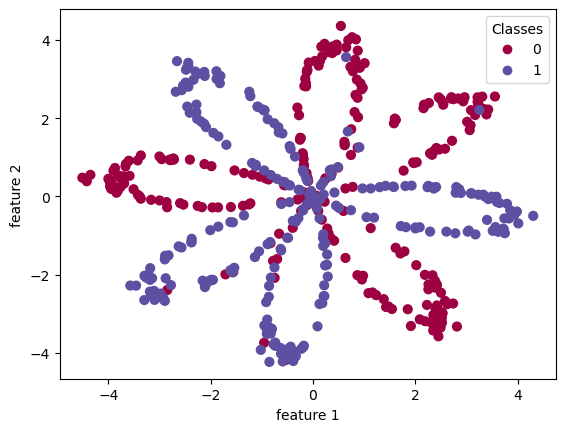

In [3]:
X_np, Y_np = h.load_flower_dataset(num_samples=500, petals=4, angle=30)
h.plot_scatter(X_np, Y_np)

In [4]:
X = tf.convert_to_tensor(X_np, dtype=tf.float32)   # shape=(2,500)=(d,m)
Y = tf.convert_to_tensor(Y_np, dtype=tf.float32)   # shape=(1,500)=(1,m)

# Code with<a id="03"></a>

# 1- custom z, gradient update, accuracy<a id="03-1"></a>

In [52]:
%reset_selective -f ^(?!X$|Y$|tf$|k$|h$|np$|X_np$|Y_np$).*

## Hyperparameters
num_epochs = 10000
learning_rate = 0.5
n_h = 4     # number of hidden units

costs = []                                        # To keep track of the cost
train_acc = []
print_cost=True

## layer_sizes
n_x = X.shape[0] # size of input layer
n_h = n_h        # size of hidden layer
n_y = Y.shape[0] # size of output layer

## Initialize parameters
# tf.random.set_seed(3)
# W1 = tf.Variable( tf.random.normal((n_h, n_x)) * 0.01)
# b1 = tf.Variable( tf.zeros((n_h, 1)) )
# W2 = tf.Variable( tf.random.normal((n_y, n_h)) * 0.01)
# b2 = tf.Variable( tf.zeros((n_y, 1)) )
np.random.seed(3)
W1 = tf.Variable( np.random.randn(n_h, n_x) * 0.01, dtype=tf.float32)
b1 = tf.Variable( tf.zeros((n_h, 1)) )
W2 = tf.Variable( np.random.randn(n_y, n_h) * 0.01, dtype=tf.float32)
b2 = tf.Variable( tf.zeros((n_y, 1)) )

## epochs loop
for i in range(num_epochs): 
    ## Forward propagation(FROM X TO A2)
    with tf.GradientTape() as tape:
        Z1 = tf.matmul(W1,X) + b1        # shape(n_h,m) = (n_h,d)(d,m) + (n_h,1)
        A1 = tf.tanh(Z1)             # shape(n_h,m)
        Z2 = tf.matmul(W2,A1) + b2   # shape(n_y,m) = (n_y,n_h)(n_h,m) + (n_y,1)
        A2 = 1/(1 + tf.exp(-Z2))     # shape(n_y,m)
        Y_pred = A2
        # cost = k.losses.binary_crossentropy(Y, z, from_logits=True)
        cost = k.losses.binary_crossentropy(Y, Y_pred, from_logits=False)
    
    ## backward pass: gradients finding
    grads = tape.gradient(cost, [W1, b1, W2, b2])
    ## update parameters
    W1.assign_sub(learning_rate * grads[0])
    b1.assign_sub(learning_rate * grads[1])
    W2.assign_sub(learning_rate * grads[2])
    b2.assign_sub(learning_rate * grads[3])

    ## Record the costs
    if i % 100 == 0 or i == num_epochs-1:
        costs.append(cost.numpy().item())
        ## Binary Accuracy
        Y_pred_out = tf.cast(Y_pred > 0.5, tf.float32)
        acc = tf.reduce_mean( tf.cast(Y_pred_out == Y, tf.float32) )
        train_acc.append(acc.numpy().item()*100)
        ## Print the cost every 100 training epochs
        if print_cost:
            print(f"Cost in epochs {i+1}, {cost.numpy().item()}")

## Predict train/test set examples
Z1 = tf.matmul(W1,X) + b1    # shape(n_h,m) = (n_h,d)(d,m) + (n_h,1)
A1 = tf.tanh(Z1)             # shape(n_h,m)
Z2 = tf.matmul(W2,A1) + b2   # shape(n_y,m) = (n_y,n_h)(n_h,m) + (n_y,1)
Y_pred = 1/(1 + tf.exp(-Z2))     # shape(n_y,m)
Y_pred_out = tf.cast(Y_pred > 0.5, "float32")   # shape(1,m); EagerTensor float32

## Print train/test Errors
if print_cost:
    acc = tf.reduce_mean( tf.cast(Y_pred_out == Y, tf.float32) )
    print(f"train accuracy: { acc.numpy().item() *100 } %")

Cost in epochs 1, 0.6931666135787964
Cost in epochs 101, 0.5787063241004944
Cost in epochs 201, 0.5548058152198792
Cost in epochs 301, 0.3220624029636383
Cost in epochs 401, 0.26842790842056274
Cost in epochs 501, 0.2509467303752899
Cost in epochs 601, 0.24199257791042328
Cost in epochs 701, 0.23637768626213074
Cost in epochs 801, 0.23246526718139648
Cost in epochs 901, 0.22954046726226807
Cost in epochs 1000, 0.22724978625774384
train accuracy: 91.20000004768372 %


# 2- custom z, gradient update<a id="03-2"></a>

In [5]:
%reset_selective -f ^(?!X$|Y$|tf$|k$|h$|np$|X_np$|Y_np$).*

## Hyperparameters
num_epochs = 10000
learning_rate = 0.5
n_h = 4     # number of hidden units

costs = []                                        # To keep track of the cost
train_acc = []
print_cost=True

## layer_sizes
n_x = X.shape[0] # size of input layer
n_h = n_h        # size of hidden layer
n_y = Y.shape[0] # size of output layer

## Initialize parameters
# tf.random.set_seed(3)
# W1 = tf.Variable( tf.random.normal((n_h, n_x)) * 0.01)
# b1 = tf.Variable( tf.zeros((n_h, 1)) )
# W2 = tf.Variable( tf.random.normal((n_y, n_h)) * 0.01)
# b2 = tf.Variable( tf.zeros((n_y, 1)) )
np.random.seed(3)
W1 = tf.Variable( np.random.randn(n_h, n_x) * 0.01, dtype=tf.float32)
b1 = tf.Variable( tf.zeros((n_h, 1)) )
W2 = tf.Variable( np.random.randn(n_y, n_h) * 0.01, dtype=tf.float32)
b2 = tf.Variable( tf.zeros((n_y, 1)) )

## epochs loop
for i in range(num_epochs): 
    ## forward pass
    with tf.GradientTape() as tape:
        Z1 = tf.matmul(W1,X) + b1        # shape(n_h,m) = (n_h,d)(d,m) + (n_h,1)
        A1 = tf.tanh(Z1)             # shape(n_h,m)
        Z2 = tf.matmul(W2,A1) + b2   # shape(n_y,m) = (n_y,n_h)(n_h,m) + (n_y,1)
        A2 = tf.sigmoid(Z2)          # shape(n_y,m)
        Y_pred = A2
        # cost = k.losses.binary_crossentropy(Y, z, from_logits=True)
        cost = k.losses.binary_crossentropy(Y, Y_pred, from_logits=False)
    
    ## backward pass: gradients finding
    grads = tape.gradient(cost, [W1, b1, W2, b2])
    ## update parameters
    W1.assign_sub(learning_rate * grads[0])
    b1.assign_sub(learning_rate * grads[1])
    W2.assign_sub(learning_rate * grads[2])
    b2.assign_sub(learning_rate * grads[3])

    ## Record the costs
    if i % 100 == 0 or i == num_epochs-1:
        costs.append(cost.numpy().item())
        ## Binary Accuracy
        acc = tf.keras.metrics.binary_accuracy(Y, Y_pred, threshold=0.5)
        train_acc.append(acc.numpy().item()*100)
        ## Print the cost every 100 training epochs
        if print_cost:
            print(f"Cost in epochs {i+1}, {cost.numpy().item()}")

## Predict train/test set examples
Z1 = tf.matmul(W1,X) + b1        # shape(n_h,m) = (n_h,d)(d,m) + (n_h,1)
A1 = tf.tanh(Z1)             # shape(n_h,m)
Z2 = tf.matmul(W2,A1) + b2   # shape(n_y,m) = (n_y,n_h)(n_h,m) + (n_y,1)
A2 = tf.sigmoid(Z2)          # shape(n_y,m)
Y_pred_out = tf.cast(Y_pred > 0.5, "float32")   # shape(1,m); EagerTensor float32

## Print train/test Errors
if print_cost:
    acc = tf.keras.metrics.binary_accuracy(Y, Y_pred, threshold=0.5)
    print(f"train accuracy: { acc.numpy().item() *100} %")

Cost in epochs 1, 0.6931666135787964
Cost in epochs 101, 0.5787063837051392
Cost in epochs 201, 0.5548076033592224
Cost in epochs 301, 0.322135329246521
Cost in epochs 401, 0.2684270143508911
Cost in epochs 501, 0.25095289945602417
Cost in epochs 601, 0.24199165403842926
Cost in epochs 701, 0.23637795448303223
Cost in epochs 801, 0.2324741780757904
Cost in epochs 901, 0.22954025864601135
Cost in epochs 1001, 0.2272435426712036
Cost in epochs 1101, 0.2253805249929428
Cost in epochs 1201, 0.22379107773303986
Cost in epochs 1301, 0.2224263846874237
Cost in epochs 1401, 0.2212340384721756
Cost in epochs 1501, 0.2201552838087082
Cost in epochs 1601, 0.21916814148426056
Cost in epochs 1701, 0.21828894317150116
Cost in epochs 1801, 0.2174566388130188
Cost in epochs 1901, 0.21665948629379272
Cost in epochs 2001, 0.2159169763326645
Cost in epochs 2101, 0.21522264182567596
Cost in epochs 2201, 0.21455217897891998
Cost in epochs 2301, 0.2139066755771637
Cost in epochs 2401, 0.21328486502170563
Co

# 3- optimizer, custom z<a id="03-3"></a>

In [6]:
%reset_selective -f ^(?!X$|Y$|tf$|k$|h$|right_logger$|wrong_logger$|np$|X_np$|Y_np$).*

## Hyperparameters
num_epochs = 10000
learning_rate = 0.5
n_h = 4     # number of hidden units

costs = []                                        # To keep track of the cost
train_acc = []
print_cost=True

## layer_sizes
n_x = X.shape[0] # size of input layer
n_h = n_h        # size of hidden layer
n_y = Y.shape[0] # size of output layer

## Initialize parameters
# tf.random.set_seed(3)
# W1 = tf.Variable( tf.random.normal((n_h, n_x)) * 0.01)
# b1 = tf.Variable( tf.zeros((n_h, 1)) )
# W2 = tf.Variable( tf.random.normal((n_y, n_h)) * 0.01)
# b2 = tf.Variable( tf.zeros((n_y, 1)) )
np.random.seed(3)
W1 = tf.Variable( np.random.randn(n_h, n_x) * 0.01, dtype=tf.float32)
b1 = tf.Variable( tf.zeros((n_h, 1)) )
W2 = tf.Variable( np.random.randn(n_y, n_h) * 0.01, dtype=tf.float32)
b2 = tf.Variable( tf.zeros((n_y, 1)) )

optimizer = tf.keras.optimizers.SGD(learning_rate)

## epochs loop
for i in range(num_epochs): 
    ## forward pass
    with tf.GradientTape() as tape:
        Z1 = tf.matmul(W1,X) + b1        # shape(n_h,m) = (n_h,d)(d,m) + (n_h,1)
        A1 = tf.tanh(Z1)             # shape(n_h,m)
        Z2 = tf.matmul(W2,A1) + b2   # shape(n_y,m) = (n_y,n_h)(n_h,m) + (n_y,1)
        A2 = 1/(1 + tf.exp(-Z2))     # shape(n_y,m)
        Y_pred = A2
        # cost = k.losses.binary_crossentropy(Y, z, from_logits=True)
        cost = k.losses.binary_crossentropy(Y, Y_pred, from_logits=False)
    
    ## backward pass
    grads = tape.gradient(cost, [W1, b1, W2, b2])
    # right_logger.info(f"trainable_weights: \n {W1}, {b1}, {W2}, {b2}")
    # right_logger.info(f"grads: \n {grads}")
    optimizer.apply_gradients(zip(grads, [W1, b1, W2, b2]))

    ## Record the costs
    if i % 100 == 0 or i == num_epochs-1:
        costs.append(cost.numpy().item())
        ## Binary Accuracy
        acc = k.metrics.binary_accuracy(Y, Y_pred, threshold=0.5)
        train_acc.append(acc.numpy().item()*100)
        ## Print the cost every 100 training epochs
        if print_cost:
            print(f"Cost in epochs {i+1}, {cost.numpy().item()}")

## Predict train/test set examples
Z1 = tf.matmul(W1,X) + b1    # shape(n_h,m) = (n_h,d)(d,m) + (n_h,1)
A1 = tf.tanh(Z1)             # shape(n_h,m)
Z2 = tf.matmul(W2,A1) + b2   # shape(n_y,m) = (n_y,n_h)(n_h,m) + (n_y,1)
Y_pred = 1/(1 + tf.exp(-Z2))     # shape(n_y,m)
Y_pred_out = tf.cast(Y_pred > 0.5, "float32")   # shape(1,m); EagerTensor float32

## Print train/test Errors
if print_cost:
    acc = k.metrics.binary_accuracy(Y, Y_pred, threshold=0.5)
    print(f"train accuracy: { acc.numpy().item() *100} %")

Cost in epochs 1, 0.6931666135787964
Cost in epochs 101, 0.5787063241004944
Cost in epochs 201, 0.5548058152198792
Cost in epochs 301, 0.3220624029636383
Cost in epochs 401, 0.26842790842056274
Cost in epochs 501, 0.2509467303752899
Cost in epochs 601, 0.24199257791042328
Cost in epochs 701, 0.23637768626213074
Cost in epochs 801, 0.23246526718139648
Cost in epochs 901, 0.22954046726226807
Cost in epochs 1001, 0.22723917663097382
Cost in epochs 1101, 0.22537842392921448
Cost in epochs 1201, 0.2237933725118637
Cost in epochs 1301, 0.22242704033851624
Cost in epochs 1401, 0.2212340086698532
Cost in epochs 1501, 0.22015340626239777
Cost in epochs 1601, 0.21916915476322174
Cost in epochs 1701, 0.21828308701515198
Cost in epochs 1801, 0.21745654940605164
Cost in epochs 1901, 0.21665892004966736
Cost in epochs 2001, 0.21591851115226746
Cost in epochs 2101, 0.21522071957588196
Cost in epochs 2201, 0.21455170214176178
Cost in epochs 2301, 0.21391022205352783
Cost in epochs 2401, 0.213286325335

# Note1 - layer accessing parameters ways<a id="note1"></a>

In [7]:
z_node = k.layers.Dense(units=1,use_bias=True, input_shape=(2,),
 kernel_initializer="zeros", bias_initializer="zeros")
a=tf.constant([[2,3],[3,4],[4,7]])
print("z_node(X) = ", z_node(a))

print("---------------------------")
print("z_node.weights = ", z_node.weights)
print("---------------------------")
print("z_node.trainable_weights = ", z_node.trainable_weights)
print("---------------------------")
print("z_node.variables = ", z_node.variables)
print("---------------------------")
print("z_node.trainable_variables = ", z_node.trainable_variables)

z_node(X) =  tf.Tensor(
[[0.]
 [0.]
 [0.]], shape=(3, 1), dtype=float32)
---------------------------
z_node.weights =  [<tf.Variable 'dense/kernel:0' shape=(2, 1) dtype=float32, numpy=
array([[0.],
       [0.]], dtype=float32)>, <tf.Variable 'dense/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]
---------------------------
z_node.trainable_weights =  [<tf.Variable 'dense/kernel:0' shape=(2, 1) dtype=float32, numpy=
array([[0.],
       [0.]], dtype=float32)>, <tf.Variable 'dense/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]
---------------------------
z_node.variables =  [<tf.Variable 'dense/kernel:0' shape=(2, 1) dtype=float32, numpy=
array([[0.],
       [0.]], dtype=float32)>, <tf.Variable 'dense/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]
---------------------------
z_node.trainable_variables =  [<tf.Variable 'dense/kernel:0' shape=(2, 1) dtype=float32, numpy=
array([[0.],
       [0.]], dtype=float32)>, <tf.Variable

# 4- dense layer, custom gradient update<a id="03-4"></a>

In [54]:
%reset_selective -f ^(?!X$|Y$|tf$|k$|h$|np$|X_np$|Y_np$).*

## Hyperparameters
num_epochs = 10000
learning_rate = 0.5
n_h = 4     # number of hidden units

costs = []                                        # To keep track of the cost
train_acc = []
print_cost=True

## layer_sizes
n_x = X.shape[0] # size of input layer
n_h = n_h        # size of hidden layer
n_y = Y.shape[0] # size of output layer

## Initialize parameters
# inverted parameters
np.random.seed(3)
init_W1 = (np.random.randn(n_h, n_x) * 0.01).astype(np.float32).T
init_W2 = (np.random.randn(n_y, n_h) * 0.01).astype(np.float32).T

## Initialize build-in classes
# z_node = k.layers.Dense(units=1, activation="sigmoid",use_bias=True,
#  kernel_initializer=k.initializers.RandomNormal(mean=0.0, stddev=1.0,seed=3), bias_initializer=tf.keras.initializers.Zeros())
Z1_node = k.layers.Dense(units=n_h, use_bias=True, kernel_initializer=tf.constant_initializer(init_W1),
                          bias_initializer="zeros")
Z2_node = k.layers.Dense(units=n_y, use_bias=True, kernel_initializer=tf.constant_initializer(init_W2),
                          bias_initializer="zeros")
bce = tf.keras.losses.BinaryCrossentropy( from_logits=False, reduction='sum')
# bce_logits = tf.keras.losses.BinaryCrossentropy( from_logits=True, reduction='sum')

## epochs loop
for i in range(num_epochs): 
    ## forward pass
    with tf.GradientTape() as tape:
        Z1 = Z1_node( tf.transpose(X) )  # shape(m,n_h) --> x W = X.T(m,n_x) * W(n_x,n_h)
        A1 = tf.tanh(Z1)
        Z2 = Z2_node( A1 )               # shape(m,n_y) --> x W = A1(m,n_h) * W(n_h,n_y)
        Y_pred = tf.sigmoid(Z2)          # shape(m,n_y)
        cost = bce(Y, tf.transpose(Y_pred))
    
    ## backward pass
    grads = tape.gradient(cost, [Z1_node.trainable_weights[0], Z1_node.trainable_weights[1],
                                  Z2_node.trainable_weights[0], Z2_node.trainable_weights[1]])
    ## update parameters
    Z1_node.trainable_weights[0].assign_sub(learning_rate * grads[0])
    Z1_node.trainable_weights[1].assign_sub(learning_rate * grads[1])
    Z2_node.trainable_weights[0].assign_sub(learning_rate * grads[2])
    Z2_node.trainable_weights[1].assign_sub(learning_rate * grads[3])

    ## Record the costs
    if i % 100 == 0 or i == num_epochs-1:
        costs.append(cost.numpy().item())
        ## Binary Accuracy
        acc = tf.keras.metrics.binary_accuracy(Y, tf.transpose(Y_pred), threshold=0.5)
        train_acc.append(acc.numpy().item()*100)
        ## Print the cost every 100 training epochs
        if print_cost:
            print(f"Cost in epochs {i+1}, {cost.numpy().item()}")

## Predict train/test set examples
Z1 = Z1_node( tf.transpose(X) )  # shape(m,n_h) --> x W = X.T(m,n_x) * W(n_x,n_h)
A1 = tf.tanh(Z1)
Z2 = Z2_node( A1 )               # shape(m,n_y) --> x W = A1(m,n_h) * W(n_h,n_y)
Y_pred = tf.sigmoid(Z2)          # shape(m,n_y)
Y_pred_out = tf.cast(Y_pred > 0.5, "float32")   # shape(m,1); EagerTensor float32

## Print train/test Errors
if print_cost:
    acc = tf.keras.metrics.binary_accuracy(Y, tf.transpose(Y_pred), threshold=0.5)
    print(f"train accuracy: { acc.numpy().item()*100 } %")

Cost in epochs 1, 0.6931666135787964
Cost in epochs 101, 0.5787054896354675
Cost in epochs 201, 0.5548071265220642
Cost in epochs 301, 0.3222314715385437
Cost in epochs 401, 0.2684381306171417
Cost in epochs 501, 0.2509555220603943
Cost in epochs 601, 0.24200069904327393
Cost in epochs 701, 0.23638761043548584
Cost in epochs 801, 0.23247773945331573
Cost in epochs 901, 0.22954882681369781
Cost in epochs 1000, 0.22726938128471375
train accuracy: 91.20000004768372 %


# 5 - dense layer, optimizer<a id="03-5"></a>

In [13]:
%reset_selective -f ^(?!X$|Y$|tf$|k$|h$|np$|X_np$|Y_np$).*

## Hyperparameters
num_epochs = 10000
learning_rate = 0.5
n_h = 4     # number of hidden units

costs = []                                        # To keep track of the cost
train_acc = []
print_cost=True

## layer_sizes
n_x = X.shape[0] # size of input layer
n_h = n_h        # size of hidden layer
n_y = Y.shape[0] # size of output layer

## Initialize parameters
# inverted parameters
np.random.seed(3)
init_W1 = (np.random.randn(n_h, n_x) * 0.01).astype(np.float32).T
init_W2 = (np.random.randn(n_y, n_h) * 0.01).astype(np.float32).T

## Initialize build-in classes
# z_node = k.layers.Dense(units=1, activation="sigmoid",use_bias=True,
#  kernel_initializer=k.initializers.RandomNormal(mean=0.0, stddev=1.0,seed=3), bias_initializer=tf.keras.initializers.Zeros())
Z1_node = k.layers.Dense(units=n_h, use_bias=True, kernel_initializer=tf.constant_initializer(init_W1),
                          bias_initializer="zeros")
Z2_node = k.layers.Dense(units=n_y, use_bias=True, kernel_initializer=tf.constant_initializer(init_W2),
                          bias_initializer="zeros")
bce = tf.keras.losses.BinaryCrossentropy( from_logits=False, reduction='sum')
# bce_logits = tf.keras.losses.BinaryCrossentropy( from_logits=True, reduction='sum')
optimizer = tf.keras.optimizers.SGD(learning_rate)

## epochs loop
for i in range(num_epochs): 
    ## forward pass
    with tf.GradientTape() as tape:
        Z1 = Z1_node( tf.transpose(X) )  # shape(m,n_h) --> x W = X.T(m,n_x) * W(n_x,n_h)
        A1 = tf.tanh(Z1)
        Z2 = Z2_node( A1 )               # shape(m,n_y) --> x W = A1(m,n_h) * W(n_h,n_y)
        Y_pred = tf.sigmoid(Z2)          # shape(m,n_y)
        cost = bce(Y, tf.transpose(Y_pred))
    
    ## backward pass
    grads = tape.gradient(cost, [Z1_node.trainable_weights[0], Z1_node.trainable_weights[1],
                                  Z2_node.trainable_weights[0], Z2_node.trainable_weights[1]])
    optimizer.apply_gradients(zip(grads, [Z1_node.trainable_weights[0], Z1_node.trainable_weights[1],
                                  Z2_node.trainable_weights[0], Z2_node.trainable_weights[1]]))

    ## Record the costs
    if i % 100 == 0 or i == num_epochs-1:
        costs.append(cost.numpy().item())
        ## Binary Accuracy
        acc = tf.keras.metrics.binary_accuracy(Y, tf.transpose(Y_pred), threshold=0.5)
        train_acc.append(acc.numpy().item()*100)
        ## Print the cost every 100 training epochs
        if print_cost:
            print(f"Cost in epochs {i+1}, {cost.numpy().item()}")

## Predict train/test set examples
Z1 = Z1_node( tf.transpose(X) )  # shape(m,n_h) --> x W = X.T(m,n_x) * W(n_x,n_h)
A1 = tf.tanh(Z1)
Z2 = Z2_node( A1 )               # shape(m,n_y) --> x W = A1(m,n_h) * W(n_h,n_y)
Y_pred = tf.sigmoid(Z2)          # shape(m,n_y)
Y_pred_out = tf.cast(Y_pred > 0.5, "float32")   # shape(m,1); EagerTensor float32

## Print train/test Errors
if print_cost:
    acc = tf.keras.metrics.binary_accuracy(Y, tf.transpose(Y_pred), threshold=0.5)
    print(f"train accuracy: { acc.numpy().item()*100 } %")

Cost in epochs 1, 0.6931666135787964
Cost in epochs 101, 0.5787054896354675
Cost in epochs 201, 0.5548071265220642
Cost in epochs 301, 0.3222314715385437
Cost in epochs 401, 0.2684381306171417
Cost in epochs 501, 0.2509555220603943
Cost in epochs 601, 0.24200069904327393
Cost in epochs 701, 0.23638761043548584
Cost in epochs 801, 0.23247773945331573
Cost in epochs 901, 0.22954882681369781
Cost in epochs 1001, 0.2272486388683319
Cost in epochs 1101, 0.22537043690681458
Cost in epochs 1201, 0.22378915548324585
Cost in epochs 1301, 0.2224275916814804
Cost in epochs 1401, 0.22122228145599365
Cost in epochs 1501, 0.22015027701854706
Cost in epochs 1601, 0.21917331218719482
Cost in epochs 1701, 0.21828189492225647
Cost in epochs 1801, 0.2174382358789444
Cost in epochs 1901, 0.2166651487350464
Cost in epochs 2001, 0.21591722965240479
Cost in epochs 2101, 0.21522070467472076
Cost in epochs 2201, 0.2145516723394394
Cost in epochs 2301, 0.21390216052532196
Cost in epochs 2401, 0.2132819592952728

# 6 - dense+sigmoid layer, custom gradient update<a id="03-6"></a>

In [56]:
%reset_selective -f ^(?!X$|Y$|tf$|k$|h$|np$|X_np$|Y_np$).*

## Hyperparameters
num_epochs = 10000
learning_rate = 0.5
n_h = 4     # number of hidden units

costs = []                                        # To keep track of the cost
train_acc = []
print_cost=True

## layer_sizes
n_x = X.shape[0] # size of input layer
n_h = n_h        # size of hidden layer
n_y = Y.shape[0] # size of output layer

## Initialize parameters
# inverted parameters
np.random.seed(3)
init_W1 = (np.random.randn(n_h, n_x) * 0.01).astype(np.float32).T
init_W2 = (np.random.randn(n_y, n_h) * 0.01).astype(np.float32).T

## Initialize build-in classes
# z_node = k.layers.Dense(units=1, activation="sigmoid",use_bias=True,
#  kernel_initializer=k.initializers.RandomNormal(mean=0.0, stddev=1.0,seed=3), bias_initializer=tf.keras.initializers.Zeros())
A1_node = k.layers.Dense(units=n_h, use_bias=True, activation="tanh", kernel_initializer=tf.constant_initializer(init_W1),
                          bias_initializer="zeros")
A2_node = k.layers.Dense(units=n_y, use_bias=True, activation="sigmoid", kernel_initializer=tf.constant_initializer(init_W2),
                          bias_initializer="zeros")
bce = tf.keras.losses.BinaryCrossentropy( from_logits=False, reduction='sum')

## epochs loop
for i in range(num_epochs): 
    ## forward pass
    with tf.GradientTape() as tape:
        A1 = A1_node( tf.transpose(X) )  # shape(m,n_h) --> x W = X.T(m,n_x) * W(n_x,n_h)
        Y_pred = A2_node( A1 )               # shape(m,n_y) --> x W = A1(m,n_h) * W(n_h,n_y)
        cost = bce(Y, tf.transpose(Y_pred))
    
    ## backward pass
    grads = tape.gradient(cost, [A1_node.trainable_weights, A2_node.trainable_weights])
    ## update parameters
    A1_node.trainable_weights[0].assign_sub(learning_rate * grads[0][0])
    A1_node.trainable_weights[1].assign_sub(learning_rate * grads[0][1])
    A2_node.trainable_weights[0].assign_sub(learning_rate * grads[1][0])
    A2_node.trainable_weights[1].assign_sub(learning_rate * grads[1][1])

    ## Record the costs
    if i % 100 == 0 or i == num_epochs-1:
        costs.append(cost.numpy().item())
        ## Binary Accuracy
        acc = tf.keras.metrics.binary_accuracy(Y, tf.transpose(Y_pred), threshold=0.5)
        train_acc.append(acc.numpy().item()*100)
        ## Print the cost every 100 training epochs
        if print_cost:
            print(f"Cost in epochs {i+1}, {cost.numpy().item()}")

## Predict train/test set examples
A1 = A1_node( tf.transpose(X) )  # shape(m,n_h) --> x W = X.T(m,n_x) * W(n_x,n_h)
Y_pred = A2_node( A1 )               # shape(m,n_y) --> x W = A1(m,n_h) * W(n_h,n_y)
Y_pred_out = tf.cast(Y_pred > 0.5, "float32")   # shape(1,m); EagerTensor float32

## Print train/test Errors
if print_cost:
    acc = tf.keras.metrics.binary_accuracy(Y, tf.transpose(Y_pred), threshold=0.5)
    print(f"train accuracy: { acc.numpy().item()*100 } %")

Cost in epochs 1, 0.6931666135787964
Cost in epochs 101, 0.5787054896354675
Cost in epochs 201, 0.5548071265220642
Cost in epochs 301, 0.3222314715385437
Cost in epochs 401, 0.2684381306171417
Cost in epochs 501, 0.2509555220603943
Cost in epochs 601, 0.24200069904327393
Cost in epochs 701, 0.23638761043548584
Cost in epochs 801, 0.23247773945331573
Cost in epochs 901, 0.22954882681369781
Cost in epochs 1000, 0.22726938128471375
train accuracy: 91.20000004768372 %


# 7- dense+sigmoid layer, optimizer<a id="03-7"></a>

In [31]:
%reset_selective -f ^(?!X$|Y$|tf$|k$|h$|np$|X_np$|Y_np$).*

## Hyperparameters
num_epochs = 10000
learning_rate = 0.5
n_h = 4     # number of hidden units

costs = []                                        # To keep track of the cost
train_acc = []
print_cost=True

## layer_sizes
n_x = X.shape[0] # size of input layer
n_h = n_h        # size of hidden layer
n_y = Y.shape[0] # size of output layer

## Initialize parameters
# inverted parameters
np.random.seed(3)
init_W1 = (np.random.randn(n_h, n_x) * 0.01).astype(np.float32).T
init_W2 = (np.random.randn(n_y, n_h) * 0.01).astype(np.float32).T

## Initialize build-in classes
# z_node = k.layers.Dense(units=1, activation="sigmoid",use_bias=True,
#  kernel_initializer=k.initializers.RandomNormal(mean=0.0, stddev=1.0,seed=3), bias_initializer=tf.keras.initializers.Zeros())
A1_node = k.layers.Dense(units=n_h, use_bias=True, activation="tanh", kernel_initializer=tf.constant_initializer(init_W1),
                          bias_initializer="zeros")
A2_node = k.layers.Dense(units=n_y, use_bias=True, activation="sigmoid", kernel_initializer=tf.constant_initializer(init_W2),
                          bias_initializer="zeros")
bce = tf.keras.losses.BinaryCrossentropy( from_logits=False, reduction='sum')

optimizer = tf.keras.optimizers.SGD(learning_rate)

## epochs loop
for i in range(num_epochs): 
    ## forward pass
    with tf.GradientTape() as tape:
        A1 = A1_node( tf.transpose(X) )  # shape(m,n_h) --> x W = X.T(m,n_x) * W(n_x,n_h)
        Y_pred = A2_node( A1 )               # shape(m,n_y) --> x W = A1(m,n_h) * W(n_h,n_y)
        cost = bce(Y, tf.transpose(Y_pred))
    
    ## backward pass
    grads = tape.gradient(cost, [A1_node.trainable_weights[0], A1_node.trainable_weights[1],
                                  A2_node.trainable_weights[0], A2_node.trainable_weights[1]])
    optimizer.apply_gradients(zip(grads, [A1_node.trainable_weights[0], A1_node.trainable_weights[1],
                                  A2_node.trainable_weights[0], A2_node.trainable_weights[1]]))

    ## Record the costs
    if i % 100 == 0 or i == num_epochs-1:
        costs.append(cost.numpy().item())
        ## Binary Accuracy
        acc = tf.keras.metrics.binary_accuracy(Y, tf.transpose(Y_pred), threshold=0.5)
        train_acc.append(acc.numpy().item()*100)
        ## Print the cost every 100 training epochs
        if print_cost:
            print(f"Cost in epochs {i+1}, {cost.numpy().item()}")

## Predict train/test set examples
A1 = A1_node( tf.transpose(X) )  # shape(m,n_h) --> x W = X.T(m,n_x) * W(n_x,n_h)
Y_pred = A2_node( A1 )               # shape(m,n_y) --> x W = A1(m,n_h) * W(n_h,n_y)
Y_pred_out = tf.cast(Y_pred > 0.5, "float32")   # shape(1,m); EagerTensor float32

## Print train/test Errors
if print_cost:
    acc = tf.keras.metrics.binary_accuracy(Y, tf.transpose(Y_pred), threshold=0.5)
    print(f"train accuracy: { acc.numpy().item()*100 } %")

Cost in epochs 1, 0.6931666135787964
Cost in epochs 101, 0.5787054896354675
Cost in epochs 201, 0.5548071265220642
Cost in epochs 301, 0.3222314715385437
Cost in epochs 401, 0.2684381306171417
Cost in epochs 501, 0.2509555220603943
Cost in epochs 601, 0.24200069904327393
Cost in epochs 701, 0.23638761043548584
Cost in epochs 801, 0.23247773945331573
Cost in epochs 901, 0.22954882681369781
Cost in epochs 1001, 0.2272486388683319
Cost in epochs 1101, 0.22537043690681458
Cost in epochs 1201, 0.22378915548324585
Cost in epochs 1301, 0.2224275916814804
Cost in epochs 1401, 0.22122228145599365
Cost in epochs 1501, 0.22015027701854706
Cost in epochs 1601, 0.21917331218719482
Cost in epochs 1701, 0.21828189492225647
Cost in epochs 1801, 0.2174382358789444
Cost in epochs 1901, 0.2166651487350464
Cost in epochs 2001, 0.21591722965240479
Cost in epochs 2101, 0.21522070467472076
Cost in epochs 2201, 0.2145516723394394
Cost in epochs 2301, 0.21390216052532196
Cost in epochs 2401, 0.2132819592952728

# Note2 - model accessing parameters ways<a id="note2"></a>

In [12]:
model = k.models.Sequential()
model.add( k.layers.Dense(units=1, activation='sigmoid', input_shape=(2,),kernel_initializer="zeros",
    bias_initializer="zeros") )

# model.layer[0] works in all below cases
print("model.variables = ", model.variables)
print("---------------------------")
print("model.trainable_variables = ", model.trainable_variables)
print("---------------------------")
print("model.weights = ", model.weights)
print("---------------------------")
print("model.trainable_weights = ", model.trainable_weights)

model.variables =  [<tf.Variable 'dense_5/kernel:0' shape=(2, 1) dtype=float32, numpy=
array([[0.],
       [0.]], dtype=float32)>, <tf.Variable 'dense_5/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]
---------------------------
model.trainable_variables =  [<tf.Variable 'dense_5/kernel:0' shape=(2, 1) dtype=float32, numpy=
array([[0.],
       [0.]], dtype=float32)>, <tf.Variable 'dense_5/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]
---------------------------
model.weights =  [<tf.Variable 'dense_5/kernel:0' shape=(2, 1) dtype=float32, numpy=
array([[0.],
       [0.]], dtype=float32)>, <tf.Variable 'dense_5/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]
---------------------------
model.trainable_weights =  [<tf.Variable 'dense_5/kernel:0' shape=(2, 1) dtype=float32, numpy=
array([[0.],
       [0.]], dtype=float32)>, <tf.Variable 'dense_5/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]


# 8- sequential layer, custom gradient update<a id="03-8"></a>

In [59]:
%reset_selective -f ^(?!X$|Y$|tf$|k$|h$|np$|X_np$|Y_np$).*

## Hyperparameters
num_epochs = 10000
learning_rate = 0.5
n_h = 4     # number of hidden units

costs = []                                        # To keep track of the cost
train_acc = []
print_cost=True

## layer_sizes
n_x = X.shape[0] # size of input layer
n_h = n_h        # size of hidden layer
n_y = Y.shape[0] # size of output layer

## Initialize parameters
# inverted parameters
np.random.seed(3)
init_W1 = (np.random.randn(n_h, n_x) * 0.01).astype(np.float32).T
init_W2 = (np.random.randn(n_y, n_h) * 0.01).astype(np.float32).T

## Initialize build-in classes
# z_node = k.layers.Dense(units=1, activation="sigmoid",use_bias=True,
#  kernel_initializer=k.initializers.RandomNormal(mean=0.0, stddev=1.0,seed=3), bias_initializer=tf.keras.initializers.Zeros())
forward = k.models.Sequential()
forward.add( k.layers.Dense(units=n_h, activation='tanh', use_bias=True, input_shape=(n_x,), kernel_initializer=tf.constant_initializer(init_W1),
    bias_initializer="zeros") )
forward.add( k.layers.Dense(units=n_y, activation='sigmoid', use_bias=True, input_shape=(n_h,), kernel_initializer=tf.constant_initializer(init_W2),
    bias_initializer="zeros") )
bce = tf.keras.losses.BinaryCrossentropy( from_logits=False, reduction='sum')

## epochs loop
for i in range(num_epochs): 
    ## forward pass
    with tf.GradientTape() as tape:
        Y_pred = forward( tf.transpose(X) )
        cost = bce(Y, tf.transpose(Y_pred))
    
    ## backward pass
    grads = tape.gradient(cost, forward.trainable_weights)
    ## update parameters
    # forward.layers[0].trainable_weights #to access variables of only first layer 
    forward.trainable_weights[0].assign_sub(learning_rate * grads[0])
    forward.trainable_weights[1].assign_sub(learning_rate * grads[1])
    forward.trainable_weights[2].assign_sub(learning_rate * grads[2])
    forward.trainable_weights[3].assign_sub(learning_rate * grads[3])

    ## Record the costs
    if i % 100 == 0 or i == num_epochs-1:
        costs.append(cost.numpy().item())
        ## Binary Accuracy
        acc = tf.keras.metrics.binary_accuracy(Y, tf.transpose(Y_pred), threshold=0.5)
        train_acc.append(acc.numpy().item()*100)
        ## Print the cost every 100 training epochs
        if print_cost:
            print(f"Cost in epochs {i+1}, {cost.numpy().item()}")

## Predict train/test set examples
Y_pred = forward(tf.transpose(X))    # shape(m,n_y) --> x W = A1(m,n_h) * W(n_h,n_y) 
Y_pred_out = tf.cast(Y_pred > 0.5, "float32")   # shape(m,n_y); EagerTensor float32

## Print train/test Errors
if print_cost:
    acc = tf.keras.metrics.binary_accuracy(Y, tf.transpose(Y_pred), threshold=0.5)
    print(f"train accuracy: { acc.numpy().item()*100 } %")

Cost in epochs 1, 0.6931666135787964
Cost in epochs 101, 0.5787054896354675
Cost in epochs 201, 0.5548071265220642
Cost in epochs 301, 0.3222314715385437
Cost in epochs 401, 0.2684381306171417
Cost in epochs 501, 0.2509555220603943
Cost in epochs 601, 0.24200069904327393
Cost in epochs 701, 0.23638761043548584
Cost in epochs 801, 0.23247773945331573
Cost in epochs 901, 0.22954882681369781
Cost in epochs 1000, 0.22726938128471375
train accuracy: 91.20000004768372 %


# 9- sequential layer, optimizer<a id="03-9"></a>

In [35]:
%reset_selective -f ^(?!X$|Y$|tf$|k$|h$|np$|right_logger$|wrong_logger$|X_np$|Y_np$).*

## Hyperparameters
num_epochs = 10000
learning_rate = 0.5
n_h = 4     # number of hidden units

costs = []                                        # To keep track of the cost
train_acc = []
print_cost=True

## layer_sizes
n_x = X.shape[0] # size of input layer
n_h = n_h        # size of hidden layer
n_y = Y.shape[0] # size of output layer

## Initialize parameters
# inverted parameters
np.random.seed(3)
init_W1 = (np.random.randn(n_h, n_x) * 0.01).astype(np.float32).T
init_W2 = (np.random.randn(n_y, n_h) * 0.01).astype(np.float32).T

## Initialize build-in classes
# z_node = k.layers.Dense(units=1, activation="sigmoid",use_bias=True,
#  kernel_initializer=k.initializers.RandomNormal(mean=0.0, stddev=1.0,seed=3), bias_initializer=tf.keras.initializers.Zeros())
forward = k.models.Sequential()
forward.add( k.layers.Dense(units=n_h, activation='tanh', input_shape=(n_x,),
                            kernel_initializer=tf.constant_initializer(init_W1),
                            bias_initializer="zeros") )
forward.add( k.layers.Dense(units=n_y, activation='sigmoid', input_shape=(n_h,),
                            kernel_initializer=tf.constant_initializer(init_W2),
                            bias_initializer="zeros") )
bce = tf.keras.losses.BinaryCrossentropy( from_logits=False, reduction='sum')
optimizer = tf.keras.optimizers.SGD(learning_rate)

## epochs loop
for i in range(num_epochs): 
    ## forward pass
    with tf.GradientTape() as tape:
        Y_pred = forward( tf.transpose(X) )
        cost = bce(Y, tf.transpose(Y_pred))
    
    ## backward pass
    grads = tape.gradient(cost, forward.trainable_weights)
    # wrong_logger.info(f"forward.trainable_weights: \n {forward.trainable_weights}")
    # wrong_logger.info(f"grads: \n {grads}")
    optimizer.apply_gradients(zip(grads, forward.trainable_weights))
    # forward.layers[0].trainable_weights #to access variables of only first layer 

    ## Record the costs
    if i % 100 == 0 or i == num_epochs-1:
        costs.append(cost.numpy().item())
        ## Binary Accuracy
        acc = tf.keras.metrics.binary_accuracy(Y, tf.transpose(Y_pred), threshold=0.5)
        train_acc.append(acc.numpy().item()*100)
        ## Print the cost every 100 training epochs
        if print_cost:
            print(f"Cost in epochs {i+1}, {cost.numpy().item()}")

## Predict train/test set examples
Y_pred = forward(tf.transpose(X))    # shape(m,n_y) --> x W = A1(m,n_h) * W(n_h,n_y)
Y_pred_out = tf.cast(Y_pred > 0.5, "float32")   # shape(m,n_y); EagerTensor float32

## Print train/test Errors
if print_cost:
    acc = tf.keras.metrics.binary_accuracy(Y, tf.transpose(Y_pred), threshold=0.5)
    print(f"train accuracy: { acc.numpy().item()*100 } %")

Cost in epochs 1, 0.6931666135787964
Cost in epochs 101, 0.5787054896354675
Cost in epochs 201, 0.5548071265220642
Cost in epochs 301, 0.3222314715385437
Cost in epochs 401, 0.2684381306171417
Cost in epochs 501, 0.2509555220603943
Cost in epochs 601, 0.24200069904327393
Cost in epochs 701, 0.23638761043548584
Cost in epochs 801, 0.23247773945331573
Cost in epochs 901, 0.22954882681369781
Cost in epochs 1001, 0.2272486388683319
Cost in epochs 1101, 0.22537043690681458
Cost in epochs 1201, 0.22378915548324585
Cost in epochs 1301, 0.2224275916814804
Cost in epochs 1401, 0.22122228145599365
Cost in epochs 1501, 0.22015027701854706
Cost in epochs 1601, 0.21917331218719482
Cost in epochs 1701, 0.21828189492225647
Cost in epochs 1801, 0.2174382358789444
Cost in epochs 1901, 0.2166651487350464
Cost in epochs 2001, 0.21591722965240479
Cost in epochs 2101, 0.21522070467472076
Cost in epochs 2201, 0.2145516723394394
Cost in epochs 2301, 0.21390216052532196
Cost in epochs 2401, 0.2132819592952728

# 10- class z, custom gradient update<a id="03-10"></a>

In [62]:
%reset_selective -f ^(?!X$|Y$|tf$|k$|h$|np$|X_np$|Y_np$).*

class z_class(k.layers.Layer):
    def __init__(self, units, init_W):
        super().__init__()
        self.units = units
        self.init_W = init_W

    # Create the state of the layer (weights)
    def build(self, input_shape):
        self.kernel = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer=tf.constant_initializer(self.init_W),
            trainable=True,
            name="kernel",
        )
        # k.initializers.RandomNormal(mean=0.0, stddev=1.0,seed=3)
        self.bias = self.add_weight(
            shape=(self.units,),
            initializer="zeros",
            trainable=True,
            name="bias",
        )

    # Defines the computation
    def call(self, inputs):
        return tf.matmul(inputs, self.kernel) + self.bias

## Hyperparameters
num_epochs = 10000
learning_rate = 0.5
n_h = 4     # number of hidden units

costs = []                                        # To keep track of the cost
train_acc = []
print_cost=True

## layer_sizes
n_x = X.shape[0] # size of input layer
n_h = n_h        # size of hidden layer
n_y = Y.shape[0] # size of output layer

## Initialize parameters
# inverted parameters
np.random.seed(3)
init_W1 = (np.random.randn(n_h, n_x) * 0.01).astype(np.float32).T
init_W2 = (np.random.randn(n_y, n_h) * 0.01).astype(np.float32).T

## Initialize build-in classes
Z1_node = z_class(units=n_h, init_W=init_W1)
Z2_node = z_class(units=n_y, init_W=init_W2)
bce = k.losses.BinaryCrossentropy( from_logits=False, reduction='sum')
# bce_logits = k.losses.BinaryCrossentropy( from_logits=True, reduction='sum')

## epochs loop
for i in range(num_epochs): 
    ## forward pass
    with tf.GradientTape() as tape:
        Z1 = Z1_node( tf.transpose(X) )  # shape(m,n_h) --> x W = X.T(m,n_x) * W(n_x,n_h)
        A1 = tf.tanh(Z1)
        Z2 = Z2_node( A1 )               # shape(m,n_y) --> x W = A1(m,n_h) * W(n_h,n_y)
        Y_pred = tf.sigmoid(Z2)          # shape(m,n_y)
        cost = bce(Y, tf.transpose(Y_pred))
    
    ## backward pass
    grads = tape.gradient(cost, [Z1_node.trainable_weights[0], Z1_node.trainable_weights[1],
                                  Z2_node.trainable_weights[0], Z2_node.trainable_weights[1]])
    ## update parameters
    Z1_node.trainable_weights[0].assign_sub(learning_rate * grads[0])
    Z1_node.trainable_weights[1].assign_sub(learning_rate * grads[1])
    Z2_node.trainable_weights[0].assign_sub(learning_rate * grads[2])
    Z2_node.trainable_weights[1].assign_sub(learning_rate * grads[3])

    ## Record the costs
    if i % 100 == 0 or i == num_epochs-1:
        costs.append(cost.numpy().item())
        ## Binary Accuracy
        acc = tf.keras.metrics.binary_accuracy(Y, tf.transpose(Y_pred), threshold=0.5)
        train_acc.append(acc.numpy().item()*100)
        ## Print the cost every 100 training epochs
        if print_cost:
            print(f"Cost in epochs {i+1}, {cost.numpy().item()}")

## Predict train/test set examples
Z1 = Z1_node( tf.transpose(X) )  # shape(m,n_h) --> x W = X.T(m,n_x) * W(n_x,n_h)
A1 = tf.tanh(Z1)
Z2 = Z2_node( A1 )               # shape(m,n_y) --> x W = A1(m,n_h) * W(n_h,n_y)
Y_pred = tf.sigmoid(Z2)          # shape(m,n_y)
Y_pred_out = tf.cast(Y_pred > 0.5, "float32")   # shape(m,1); EagerTensor float32

## Print train/test Errors
if print_cost:
    acc = tf.keras.metrics.binary_accuracy(Y, tf.transpose(Y_pred), threshold=0.5)
    print(f"train accuracy: { acc.numpy().item()*100 } %")

Cost in epochs 1, 0.6931666135787964
Cost in epochs 101, 0.5787054896354675
Cost in epochs 201, 0.5548071265220642
Cost in epochs 301, 0.3222314417362213
Cost in epochs 401, 0.2684381306171417
Cost in epochs 501, 0.2509555220603943
Cost in epochs 601, 0.24200069904327393
Cost in epochs 701, 0.23638761043548584
Cost in epochs 801, 0.23247775435447693
Cost in epochs 901, 0.22954879701137543
Cost in epochs 1000, 0.22726938128471375
train accuracy: 91.20000004768372 %


# 11- class z, optimizer<a id="03-11"></a>

In [44]:
%reset_selective -f ^(?!X$|Y$|tf$|k$|h$|np$|X_np$|Y_np$).*

class z_class(k.layers.Layer):
    def __init__(self, units, init_W):
        super().__init__()
        self.units = units
        self.init_W = init_W

    # Create the state of the layer (weights)
    def build(self, input_shape):
        self.kernel = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer=tf.constant_initializer(self.init_W),
            trainable=True,
            name="kernel",
        )
        # k.initializers.RandomNormal(mean=0.0, stddev=1.0,seed=3)
        self.bias = self.add_weight(
            shape=(self.units,),
            initializer="zeros",
            trainable=True,
            name="bias",
        )

    # Defines the computation
    def call(self, inputs):
        return tf.matmul(inputs, self.kernel) + self.bias

## Hyperparameters
num_epochs = 10000
learning_rate = 0.5
n_h = 4     # number of hidden units

costs = []                                        # To keep track of the cost
train_acc = []
print_cost=True

## layer_sizes
n_x = X.shape[0] # size of input layer
n_h = n_h        # size of hidden layer
n_y = Y.shape[0] # size of output layer

## Initialize parameters
# inverted parameters
np.random.seed(3)
init_W1 = (np.random.randn(n_h, n_x) * 0.01).astype(np.float32).T
init_W2 = (np.random.randn(n_y, n_h) * 0.01).astype(np.float32).T

## Initialize build-in classes
Z1_node = z_class(units=n_h, init_W=init_W1)
Z2_node = z_class(units=n_y, init_W=init_W2)
bce = k.losses.BinaryCrossentropy( from_logits=False, reduction='sum')
# bce_logits = k.losses.BinaryCrossentropy( from_logits=True, reduction='sum')
optimizer = tf.keras.optimizers.SGD(learning_rate)

## epochs loop
for i in range(num_epochs): 
    ## forward pass
    with tf.GradientTape() as tape:
        Z1 = Z1_node( tf.transpose(X) )  # shape(m,n_h) --> x W = X.T(m,n_x) * W(n_x,n_h)
        A1 = tf.tanh(Z1)
        Z2 = Z2_node( A1 )               # shape(m,n_y) --> x W = A1(m,n_h) * W(n_h,n_y)
        Y_pred = tf.sigmoid(Z2)          # shape(m,n_y)
        cost = bce(Y, tf.transpose(Y_pred))
    
    ## backward pass
    grads = tape.gradient(cost, [Z1_node.trainable_weights[0], Z1_node.trainable_weights[1],
                                  Z2_node.trainable_weights[0], Z2_node.trainable_weights[1]])
    optimizer.apply_gradients(zip(grads, [Z1_node.trainable_weights[0], Z1_node.trainable_weights[1],
                                  Z2_node.trainable_weights[0], Z2_node.trainable_weights[1]]))

    ## Record the costs
    if i % 100 == 0 or i == num_epochs-1:
        costs.append(cost.numpy().item())
        ## Binary Accuracy
        acc = tf.keras.metrics.binary_accuracy(Y, tf.transpose(Y_pred), threshold=0.5)
        train_acc.append(acc.numpy().item()*100)
        ## Print the cost every 100 training epochs
        if print_cost:
            print(f"Cost in epochs {i+1}, {cost.numpy().item()}")

## Predict train/test set examples
Z1 = Z1_node( tf.transpose(X) )  # shape(m,n_h) --> x W = X.T(m,n_x) * W(n_x,n_h)
A1 = tf.tanh(Z1)
Z2 = Z2_node( A1 )               # shape(m,n_y) --> x W = A1(m,n_h) * W(n_h,n_y)
Y_pred = tf.sigmoid(Z2)          # shape(m,n_y)
Y_pred_out = tf.cast(Y_pred > 0.5, "float32")   # shape(m,1); EagerTensor float32

## Print train/test Errors
if print_cost:
    acc = tf.keras.metrics.binary_accuracy(Y, tf.transpose(Y_pred), threshold=0.5)
    print(f"train accuracy: { acc.numpy().item()*100 } %")

Cost in epochs 1, 0.6931666135787964
Cost in epochs 101, 0.5787054896354675
Cost in epochs 201, 0.5548071265220642
Cost in epochs 301, 0.3222314417362213
Cost in epochs 401, 0.2684381306171417
Cost in epochs 501, 0.2509555220603943
Cost in epochs 601, 0.24200069904327393
Cost in epochs 701, 0.23638761043548584
Cost in epochs 801, 0.23247775435447693
Cost in epochs 901, 0.22954879701137543
Cost in epochs 1001, 0.2272486537694931
Cost in epochs 1101, 0.22537042200565338
Cost in epochs 1201, 0.22378915548324585
Cost in epochs 1301, 0.2224276065826416
Cost in epochs 1401, 0.22122229635715485
Cost in epochs 1501, 0.22015029191970825
Cost in epochs 1601, 0.2191733419895172
Cost in epochs 1701, 0.21828189492225647
Cost in epochs 1801, 0.2174382358789444
Cost in epochs 1901, 0.216663658618927
Cost in epochs 2001, 0.21591724455356598
Cost in epochs 2101, 0.21522106230258942
Cost in epochs 2201, 0.21455153822898865
Cost in epochs 2301, 0.21390216052532196
Cost in epochs 2401, 0.21328195929527283

# 12- class model, optimizer<a id="03-12"></a>

In [65]:
%reset_selective -f ^(?!X$|Y$|tf$|k$|h$|np$|X_np$|Y_np$).*

class model_1hidden_layer(k.layers.Layer):
    def __init__(self, n_h=2, n_y=1, init_W1=None, init_W2=None):
        super().__init__()
        self.n_h = n_h
        self.n_y = n_y
        self.init_W1 = init_W1
        self.init_W2 = init_W2

    # Create the state of the layer (weights)
    def build(self, input_shape):
        self.kernel1 = self.add_weight(
            shape=(input_shape[-1], self.n_h),
            initializer=tf.constant_initializer(self.init_W1),
            trainable=True,
            name="kernel",
        )
        # k.initializers.RandomNormal(mean=0.0, stddev=1.0,seed=3)
        self.bias1 = self.add_weight(
            shape=(self.n_h,),
            initializer="zeros",
            trainable=True,
            name="bias",
        )
        self.kernel2 = self.add_weight(
            shape=(self.n_h, self.n_y),
            initializer=tf.constant_initializer(self.init_W2),
            trainable=True,
            name="kernel",
        )
        # k.initializers.RandomNormal(mean=0.0, stddev=1.0,seed=3)
        self.bias2 = self.add_weight(
            shape=(self.n_y,),
            initializer="zeros",
            trainable=True,
            name="bias",
        )

    # Defines the computation
    def call(self, inputs):
        Z1 = tf.matmul(inputs, self.kernel1) + self.bias1
        A1 = tf.tanh(Z1)
        Z2 = tf.matmul(A1, self.kernel2) + self.bias2
        return tf.sigmoid( Z2 )

## Hyperparameters
num_epochs = 10000
learning_rate = 0.5
n_h = 4     # number of hidden units

costs = []                                        # To keep track of the cost
train_acc = []
print_cost=True

## layer_sizes
n_x = X.shape[0] # size of input layer
n_h = n_h        # size of hidden layer
n_y = Y.shape[0] # size of output layer

## Initialize parameters
# inverted parameters
np.random.seed(3)
init_W1 = (np.random.randn(n_h, n_x) * 0.01).astype(np.float32).T
init_W2 = (np.random.randn(n_y, n_h) * 0.01).astype(np.float32).T

## Initialize build-in classes
model = model_1hidden_layer(n_h=n_h, n_y=n_y, init_W1=init_W1, init_W2=init_W2)
bce = k.losses.BinaryCrossentropy( from_logits=False, reduction='sum')
optimizer = tf.keras.optimizers.SGD(learning_rate)

## epochs loop
for i in range(num_epochs): 
    ## forward pass
    with tf.GradientTape() as tape:
        Y_pred = model( tf.transpose(X) )
        cost = bce(Y, tf.transpose(Y_pred))
    
    ## backward pass
    grads = tape.gradient(cost, model.trainable_weights)#kernel1,model.bias1,model.kernel2,model.bias2])
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    ## Record the costs
    if i % 100 == 0 or i == num_epochs-1:
        costs.append(cost.numpy().item())
        ## Binary Accuracy
        acc = tf.keras.metrics.binary_accuracy(Y, tf.transpose(Y_pred), threshold=0.5)
        train_acc.append(acc.numpy().item()*100)
        ## Print the cost every 10 training epochs
        if print_cost:
            print(f"Cost in epochs {i+1}, {cost.numpy().item()}")

## Predict train/test set examples
Y_pred = model(tf.transpose(X))    # shape(m,1) --> x W = A1(m,n_h) * W(n_h,n_y); EagerTensor float32
Y_pred_out = tf.cast(Y_pred > 0.5, "float32")   # shape(m,1); EagerTensor float32

## Print train/test Errors
if print_cost:
    acc = tf.keras.metrics.binary_accuracy(Y, tf.transpose(Y_pred), threshold=0.5)
    print(f"train accuracy: { acc.numpy().item()*100 } %")

Cost in epochs 1, 0.6931666135787964
Cost in epochs 101, 0.5787054896354675
Cost in epochs 201, 0.5548071265220642
Cost in epochs 301, 0.3222314417362213
Cost in epochs 401, 0.2684381306171417
Cost in epochs 501, 0.2509555220603943
Cost in epochs 601, 0.24200069904327393
Cost in epochs 701, 0.23638761043548584
Cost in epochs 801, 0.23247775435447693
Cost in epochs 901, 0.22954879701137543
Cost in epochs 1000, 0.22726938128471375
train accuracy: 91.20000004768372 %


# 13- tf high api<a id="03-13"></a>

In [46]:
%reset_selective -f ^(?!X$|Y$|tf$|k$|h$|np$|X_np$|Y_np$).*

## layer_sizes
n_x = X.shape[0] # size of input layer
n_h = 4        # size of hidden layer
n_y = Y.shape[0] # size of output layer
## Initialize weights
np.random.seed(3)
init_W1 = (np.random.randn(n_h, n_x) * 0.01).astype(np.float32).T
init_W2 = (np.random.randn(n_y, n_h) * 0.01).astype(np.float32).T

# Create the model
model = k.models.Sequential()
model.add( k.layers.Dense(units=n_h, activation='tanh', input_shape=(n_x,),
                           kernel_initializer=tf.constant_initializer(init_W1),
                             bias_initializer="zeros") )
model.add( k.layers.Dense(units=n_y, activation='sigmoid', input_shape=(n_h,),
                           kernel_initializer=tf.constant_initializer(init_W2),
                             bias_initializer="zeros") )
model.summary()

# Compile the model
model.compile(
    optimizer=k.optimizers.SGD(learning_rate=0.5),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[k.metrics.BinaryAccuracy()],
)

# Train the model
hist = model.fit(tf.transpose(X), tf.transpose(Y), epochs=10000, shuffle=False, batch_size=X.shape[1])

# Evaluate the model on the test data
loss, accuracy = model.evaluate(tf.transpose(X), tf.transpose(Y))
print('Test loss:', loss)
print('Test accuracy:', accuracy)
# hist.history["binary_accuracy"]
# hist.history["loss"]

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_38 (Dense)            (None, 4)                 12        
                                                                 
 dense_39 (Dense)            (None, 1)                 5         
                                                                 
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10000
1/1 [==============================] - 0s 454ms/step - loss: 0.6932 - binary_accuracy: 0.4660
Epoch 2/10000
1/1 [==============================] - 0s 9ms/step - loss: 0.6931 - binary_accuracy: 0.6640
Epoch 3/10000
1/1 [==============================] - 0s 9ms/step - loss: 0.6931 - binary_accuracy: 0.4720
Epoch 4/10000
1/1 [==============================] - 0s 8ms/step - loss: 0.6931 - binary_accuracy: 0.4460
Epoch 5/10000
1/1 [=========

# Result plot<a id="04"></a>

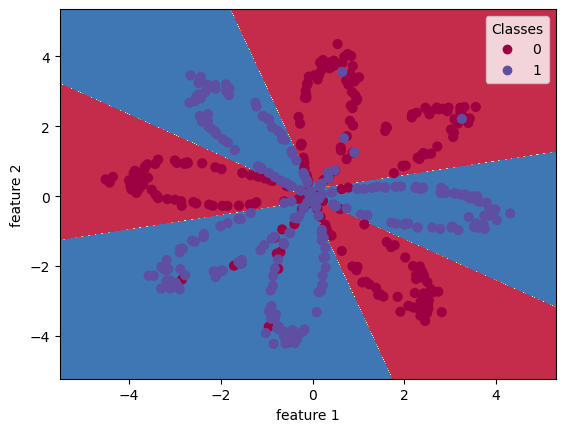

In [66]:
## custom z
# h.plot_1hidden_layer_nn_decision_boundary(W1.numpy(), b1.numpy(), W2.numpy(), b2.numpy(), X.numpy(), Y.numpy())
## dense layer
# h.plot_1hidden_layer_nn_decision_boundary(Z1_node.weights[0].numpy().T, Z1_node.weights[1].numpy().reshape(-1,1), Z2_node.weights[0].numpy().T, Z2_node.weights[1].numpy().reshape(-1,1), X.numpy(), Y.numpy())
## dense+sigmoid layer
# h.plot_1hidden_layer_nn_decision_boundary(A1_node.weights[0].numpy().T, A1_node.weights[1].numpy().reshape(-1,1), A2_node.weights[0].numpy().T, A2_node.weights[1].numpy().reshape(-1,1), X.numpy(), Y.numpy())
## sequential layer
# h.plot_1hidden_layer_nn_decision_boundary(forward.weights[0].numpy().T, forward.weights[1].numpy().reshape(-1,1), forward.weights[2].numpy().T, forward.weights[3].numpy().reshape(-1,1), X.numpy(), Y.numpy())
## class z
# h.plot_1hidden_layer_nn_decision_boundary(Z1_node.weights[0].numpy().T, Z1_node.weights[1].numpy().reshape(-1,1), Z2_node.weights[0].numpy().T, Z2_node.weights[1].numpy().reshape(-1,1), X.numpy(), Y.numpy())
## class model
# h.plot_1hidden_layer_nn_decision_boundary(model.weights[0].numpy().T, model.weights[1].numpy().reshape(-1,1), model.weights[2].numpy().T, 
#     model.weights[3].numpy().reshape(-1,1), X.numpy(), Y.numpy())
## tensorflow
h.plot_1hidden_layer_nn_decision_boundary(model.weights[0].numpy().T, model.weights[1].numpy().reshape(-1,1), model.weights[2].numpy().T, 
    model.weights[3].numpy().reshape(-1,1), X.numpy(), Y.numpy())